In [1]:
import yaml
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from umap.umap_ import UMAP
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

/opt/homebrew/anaconda3/envs/IS/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load YAML data
def load_yaml_articles(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        articles = yaml.safe_load(file)
    return articles


articles = load_yaml_articles('articles.yaml')

In [3]:
from urllib.parse import urlparse
import re

def extract_topics_from_url(url, skip_last_n=2):
    path = urlparse(url).path
    parts = [part for part in path.strip("/").split("/") if part]

    if len(parts) > skip_last_n:
        topics = parts[:-skip_last_n]
    else:
        topics = []

    # Replace hyphens with spaces, remove numbers if needed, clean up
    topics = [re.sub(r'[-_]+', ' ', topic) for topic in topics]

    return topics


In [4]:
# Assuming articles are loaded like this:
# articles = load_yaml_articles('articles.yaml')

for article in articles:
    article['url_topics'] = extract_topics_from_url(article['url'])

# Verify:
print(articles[0]['url_topics'])

['svet', 'preberite tudi']


In [5]:
num = 2
print(articles[num].get('topics'))
print(articles[num].get('url'))

slovenija
https://www.rtvslo.si/slovenija/preberite-tudi/v-veljavi-podrazitve-napotitev-delavcev/693324


In [6]:
# Extract representative texts from articles
def get_article_text(article):
    text_parts = [
        article.get('title', ''),
        article.get('lead', ''),
        ' '.join(article.get('paragraphs', [])),
    ]
    return ' '.join(text_parts)
    
# Prepare data
texts = [get_article_text(article) for article in tqdm(articles, desc="Processing articles")]


Processing articles: 100%|██████████| 29493/29493 [00:00<00:00, 332994.00it/s]


In [7]:
# ----------- TF-IDF Embeddings ----------- #
print("Generating TF-IDF embeddings...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
tfidf_embeddings = tfidf_vectorizer.fit_transform(texts)

Generating TF-IDF embeddings...


In [8]:
# ----------- SBERT Embeddings ----------- #
#print("Generating SBERT embeddings...")
#sbert_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
#sbert_embeddings = sbert_model.encode(texts, batch_size=64, show_progress_bar=True)

#np.save('sbert_embeddings.npy', sbert_embeddings)

In [9]:
sbert_embeddings = np.load('sbert_embeddings.npy')

In [10]:
# # ----------- UMAP Reduction ----------- #
# print("Reducing dimensionality with UMAP...")
# umap_reducer = UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')

# print("UMAP on TF-IDF embeddings...")
# tfidf_umap = umap_reducer.fit_transform(tfidf_embeddings)

# print("UMAP on SBERT embeddings...")
# sbert_umap = umap_reducer.fit_transform(sbert_embeddings)

# np.save('sbert_umap.npy', sbert_umap)
# np.save('tfidf_umap.npy', tfidf_umap)


In [11]:
sbert_umap = np.load('sbert_umap.npy')
tfidf_umap = np.load('tfidf_umap.npy')

t-SNE tends to form tight, visually appealing clusters. It emphasizes local neighborhood relationships strongly. While visually clearer, it can over-emphasize local neighborhoods, potentially fragmenting larger semantic clusters into artificially small subgroups.
UMAP achieves a balance between local and global structure, providing a slightly more faithful semantic representation at the expense of somewhat less visually dramatic cluster separation compared to t-SNE. UMAP embeddings typically preserve semantic continuity and relationships between clusters better than t-SNE.

Fitting PCA...


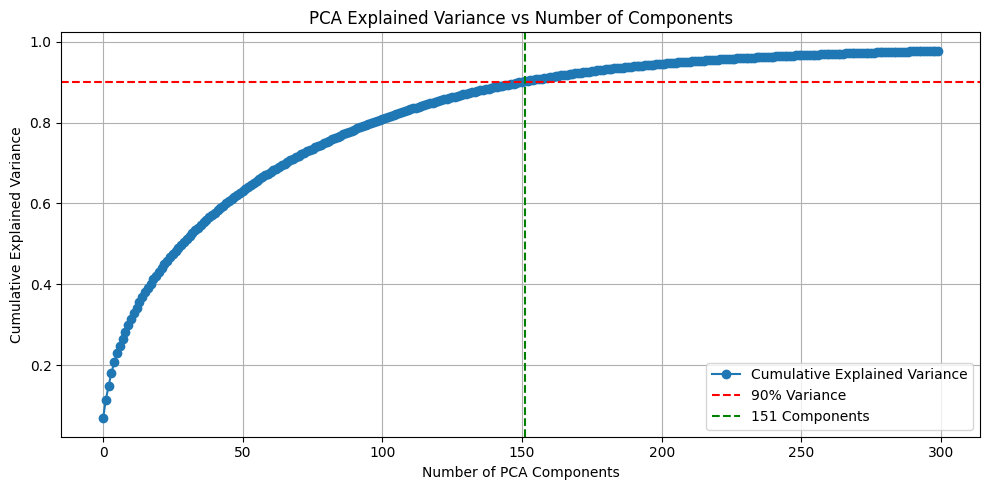

✅ 151 components retain 90% of the variance.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca_variance(embeddings, variance_threshold=0.90):
    print("Fitting PCA...")
    pca = PCA(n_components=min(300, embeddings.shape[1]))  # limit to 300 or max dims
    pca.fit(embeddings)

    # Cumulative sum of explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find how many components are needed to reach the threshold
    num_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_variance, marker='o', label='Cumulative Explained Variance')
    plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{int(variance_threshold * 100)}% Variance')
    plt.axvline(x=num_components, color='g', linestyle='--', label=f'{num_components} Components')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance vs Number of Components')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"✅ {num_components} components retain {variance_threshold*100:.0f}% of the variance.")
    return num_components

n_components_needed = plot_pca_variance(sbert_embeddings, variance_threshold=0.90)

In [13]:
from sklearn.decomposition import PCA

# Reduce SBERT embeddings to ~50D before HDBSCAN
pca = PCA(n_components=150, random_state=42)
sbert_reduced = pca.fit_transform(sbert_embeddings)

# TODO: for tfidf
# from sklearn.decomposition import TruncatedSVD

# svd = TruncatedSVD(n_components=100, random_state=42)
# tfidf_reduced = svd.fit_transform(tfidf_matrix)

# clusterer = hdbscan.HDBSCAN(min_cluster_size=70)
# tfidf_clusters = clusterer.fit_predict(tfidf_reduced)


In [14]:
from sklearn.preprocessing import normalize

umap_50d = UMAP(n_components=50, metric='cosine').fit_transform(sbert_embeddings)
umap_25d = UMAP(n_components=25, metric='cosine').fit_transform(sbert_embeddings)
normalized_embeddings = normalize(umap_50d, norm='l2')  # unit vectors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


|^| not good: PCA = linear dimensionality reduction
It keeps axes that preserve the largest variance.
But semantic similarity ≠ variance.
In text embeddings (especially SBERT), semantic structure may exist in nonlinear manifolds.
Result:
PCA might preserve noise or background features (e.g. writing style, length).
It may flatten meaningful nonlinear relationships.

In [15]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def fix_cluster_noise_with_knn(embeddings, cluster_labels, n_neighbors=5):
    """
    Reassigns HDBSCAN noise points (-1 labels) using KNN fallback.
    
    Args:
        embeddings (np.ndarray): 2D or reduced embeddings (e.g., UMAP).
        cluster_labels (np.ndarray): Cluster labels from HDBSCAN or approximate_predict().
        n_neighbors (int): Number of neighbors for KNN.

    Returns:
        np.ndarray: Final labels with no -1s (all points assigned).
    """
    cluster_labels = np.array(cluster_labels)
    noise_mask = cluster_labels == -1

    if not np.any(noise_mask):
        print("✅ No noise points to reassign. Returning original labels.")
        return cluster_labels

    print(f"🔄 Reassigning {np.sum(noise_mask)} noise points using KNN...")

    # Prepare training data (only confidently labeled points)
    X_train = embeddings[~noise_mask]
    y_train = cluster_labels[~noise_mask]

    # Train KNN and predict noise points
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    reassigned = knn.predict(embeddings[noise_mask])

    # Merge reassigned labels back into full label array
    final_labels = cluster_labels.copy()
    final_labels[noise_mask] = reassigned

    print("✅ All points now have a cluster assignment.")
    return final_labels


In [16]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder

# ----------- Clustering with HDBSCAN ----------- #
print("Clustering with HDBSCAN...")
# clusterer_tfidf = hdbscan.HDBSCAN(min_cluster_size=70, metric='euclidean')
# tfidf_clusters = clusterer_tfidf.fit_predict(tfidf_embeddings)

# Cluster with precomputed cosine distances
# TODO: min cluster size
#clusterer_sbert = hdbscan.HDBSCAN(min_cluster_size=70, metric='euclidean')
clusterer_sbert = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=100, metric='euclidean', prediction_data=True, cluster_selection_method='leaf')
# TODO: for report
#sbert_clusters = clusterer_sbert.fit_predict(sbert_umap)
#sbert_clusters = clusterer_sbert.fit_predict(umap_25d)
from hdbscan import approximate_predict

# Use HDBSCAN’s built-in prediction (only if `prediction_data=True`)
clusterer_sbert.fit(umap_25d)
sbert_clusters_sparse, strengths = approximate_predict(clusterer_sbert, umap_25d)
sbert_clusters = fix_cluster_noise_with_knn(umap_25d, sbert_clusters_sparse)


# ----------- Evaluation Metrics ----------- #
def evaluate_clusters(embeddings_2d, labels, embedding_type):
    mask = labels != -1  # Exclude noise points for fair evaluation
    if np.sum(mask) < 2:
        print(f"{embedding_type}: Not enough clustered points for evaluation.")
        return None, None

    silhouette = silhouette_score(embeddings_2d[mask], labels[mask])
    
    davies_bouldin = davies_bouldin_score(embeddings_2d[mask], labels[mask])
    print(f"{embedding_type} Silhouette Score: {silhouette:.3f}")
    print(f"{embedding_type} Davies-Bouldin Index: {davies_bouldin:.3f}")
    return silhouette, davies_bouldin

#print("\nEvaluating TF-IDF clusters:")
#evaluate_clusters(tfidf_embeddings, tfidf_clusters, "TF-IDF")

#print("\nEvaluating SBERT clusters:")
#evaluate_clusters(sbert_embeddings, sbert_clusters, "SBERT")

topic_strings = [
    "/".join(article['url_topics']) if article['url_topics'] else "no-topic"
    for article in articles
]
le = LabelEncoder()
topic_labels = le.fit_transform(topic_strings)

# Evaluate clustering
ari_score = adjusted_rand_score(topic_labels, sbert_clusters)
nmi_score = normalized_mutual_info_score(topic_labels, sbert_clusters)
print(ari_score, nmi_score)

Clustering with HDBSCAN...
🔄 Reassigning 13760 noise points using KNN...
✅ All points now have a cluster assignment.
0.18526731850665176 0.4960057519628899


In [17]:
#np.save('sbert_clusters_full.npy', sbert_clusters)

silhouette is bad for high dimensional space, overlaps, irregular shapes...

In [19]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import alphashape
from shapely.geometry import Polygon, MultiPolygon

def add_alpha_shape_outline(fig, points, group_label, col, alpha=0.2, opacity=0.1):
    try:
        shape = alphashape.alphashape(points, alpha)
        if shape is None:
            return
        if isinstance(shape, Polygon):
            polygons = [shape]
        elif isinstance(shape, MultiPolygon):
            polygons = list(shape.geoms)
        else:
            return

        for poly in polygons:
            x = list(poly.exterior.coords.xy[0])
            y = list(poly.exterior.coords.xy[1])

            fig.add_trace(
                go.Scattergl(
                    x=x,
                    y=y,
                    mode='lines',
                    line=dict(color='black', width=1, dash='dot'),
                    fill='toself',
                    fillcolor=f'rgba(0,0,0,{opacity})',
                    name=group_label,
                    legendgroup=group_label,
                    hoverinfo='text',
                    text=[group_label] * len(x),
                    showlegend=False
                ),
                row=1,
                col=col
            )
    except Exception as e:
        print(f"⚠️ Could not draw outline for group '{group_label}': {e}")

def draw_points(
    fig,
    subplot_title,
    col,
    umap_embeddings,
    clusters,
    titles,
    categories=None,
    rename_map=None,
    show_group_outlines=True,
    outline_opacity=0.05,
):
    df = pd.DataFrame({
        'x': umap_embeddings[:, 0],
        'y': umap_embeddings[:, 1],
        'cluster': clusters.astype(str),
        'title': titles,
    })

    if rename_map:
        df['group'] = [rename_map.get(int(c), "Other / Noise") for c in clusters]
    elif categories is not None:
        df['group'] = pd.Series(categories).astype(str)
    else:
        df['group'] = df['cluster']

    unique_groups = sorted(df['group'].unique())

    for group in unique_groups:
        sub_df = df[df['group'] == group]
        fig.add_trace(
            go.Scattergl(
                x=sub_df['x'],
                y=sub_df['y'],
                mode='markers',
                name=group,
                marker=dict(size=4),
                legendgroup=group,
                showlegend=True,
                hoverinfo='skip',  # ⛔ disables hover for points
            ),
            row=1,
            col=col
        )


        if show_group_outlines and len(sub_df) >= 3:
            points = sub_df[['x', 'y']].to_numpy(dtype=np.float32)
            add_alpha_shape_outline(fig, points, group, col, alpha=5, opacity=outline_opacity)

    fig.update_xaxes(title_text="UMAP 1", row=1, col=col)
    fig.update_yaxes(title_text="UMAP 2", row=1, col=col)
    fig.layout.annotations[col - 1].update(text=subplot_title)


In [20]:
print(len(set(sbert_clusters)))
#print(len(set(tfidf_clusters)))

26


In [22]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import umap
import numpy as np

def cluster_topic_paths(topic_paths, model_name='all-MiniLM-L6-v2', n_clusters=20, reduce_dim=10):
    """
    Clusters semantic topic paths using SBERT + Agglomerative clustering.
    Returns a mapping from original topic string → cluster label
    """
    print("🔄 Embedding topics...")
    model = SentenceTransformer(model_name)
    embeddings = model.encode(topic_paths, normalize_embeddings=True)

    if reduce_dim:
        print("🔽 Reducing dimensionality with UMAP...")
        reducer = umap.UMAP(n_components=reduce_dim, random_state=42, metric='cosine')
        reduced = reducer.fit_transform(embeddings)
    else:
        reduced = embeddings

    print("🔗 Clustering topic embeddings...")
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clusterer.fit_predict(reduced)

    # Create mapping
    topic_to_group = {topic: f"group_{label}" for topic, label in zip(topic_paths, labels)}
    return topic_to_group, labels

categories = [
    " / ".join(article['url_topics']) if article['url_topics'] else "no-topic"
    for article in articles
]

topic_paths = list(set(categories))  # all unique topic strings
topic_to_group, labels = cluster_topic_paths(topic_paths, n_clusters=40)

# Now map each article’s topic string to its clustered group
generalized_topic_labels = [topic_to_group.get(t, "unknown") for t in categories]
print(len(generalized_topic_labels))

🔄 Embedding topics...
🔽 Reducing dimensionality with UMAP...


/opt/homebrew/anaconda3/envs/IS/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


🔗 Clustering topic embeddings...
29493


In [23]:
import re
from collections import defaultdict, Counter

def clean_topic(topic_str):
    # Extract lowercase alphanumeric words (remove slashes, numbers, etc.)
    words = re.findall(r'\b\w+\b', topic_str.lower())
    # Exclude unwanted terms
    stop_terms = {'preberite', 'tudi'}
    return [word for word in words if word not in stop_terms]

# 1. Group topic strings by their cluster label
grouped_topics = defaultdict(list)
for topic, group in zip(categories, generalized_topic_labels):
    grouped_topics[group].append(topic)

# 2. Generate a new name per group based on top N keywords
group_name_map = {}

for group, topic_list in grouped_topics.items():
    words = [word for topic in topic_list for word in clean_topic(topic)]
    most_common_words = [word for word, _ in Counter(words).most_common(3)]  # top 3
    group_name = " | ".join(most_common_words)
    group_name_map[group] = group_name

# 3. Replace generalized_topic_labels with human-readable names
generalized_topic_labels = [group_name_map[group] for group in generalized_topic_labels]


### t-sne

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, init='pca')
tsne_2d = tsne.fit_transform(sbert_embeddings)

In [262]:
# import stanza
# from tqdm import tqdm
# # Initialize Stanza pipeline for Slovene
# stanza.download('sl')  # only once
# nlp = stanza.Pipeline('sl', processors='tokenize,pos,lemma', use_gpu=False)

# # -------------------------------
# # Preprocess: Keep only NOUN, PROPN, ADJ
# # -------------------------------
# def preprocess_text(text):
#     doc = nlp(text)
#     tokens = []
#     for sentence in doc.sentences:
#         for word in sentence.words:
#             if word.upos in ['NOUN', 'PROPN', 'ADJ']:
#                 lemma = word.lemma.lower()
#                 if len(lemma) > 2:
#                     tokens.append(lemma)
#     return ' '.join(tokens)


# # Only preprocess once per article
# preprocessed_texts = [preprocess_text(text) for text in tqdm(texts)]

2025-03-24 19:23:00 INFO: Downloaded file to /Users/matjeez/stanza_resources/resources.json
2025-03-24 19:23:00 INFO: Downloading default packages for language: sl (Slovenian) ...
2025-03-24 19:23:01 INFO: File exists: /Users/matjeez/stanza_resources/sl/default.zip
2025-03-24 19:23:02 INFO: Finished downloading models and saved to /Users/matjeez/stanza_resources
2025-03-24 19:23:02 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-03-24 19:23:02 INFO: Downloaded file to /Users/matjeez/stanza_resources/resources.json
2025-03-24 19:23:03 INFO: Loading these models for language: sl (Slovenian):
| Processor | Package      |
----------------------------
| tokenize  | ssj          |
| pos       | ssj_nocharlm |
| lemma     | ssj_nocharlm |

2025-03-24 19:23:03 INFO: Using device: cpu
2025-03-24 19:23:03 INFO: Loading: tokenize
2025-03-24 19:23:0

KeyboardInterrupt: 

In [25]:
import json

def load_combined_jsonl(filename="preprocessed_combined.jsonl"):
    with open(filename, "r", encoding="utf-8") as f:
        return [json.loads(line.strip()) for line in f if line.strip()]

# Example usage
preprocessed_texts = load_combined_jsonl()
print(f"✅ Loaded {len(preprocessed_texts)} preprocessed articles.")


✅ Loaded 29493 preprocessed articles.


In [44]:
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# You should pass in a stopword list — ideally Slovene
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')

# Setup stopwords & lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('slovene'))
def extract_cluster_keywords(texts, clusters, stop_words=list(stop_words), top_n=10, ngram_range=(1, 2)):
    """
    Extracts top n-grams (unigrams + bigrams) from preprocessed texts by cluster.
    """
    unique_clusters = np.unique(clusters[clusters >= 0])
    keywords_per_cluster = {}

    for cluster_label in unique_clusters:
        # cluster_texts = [texts[i] for i in range(len(texts)) if clusters[i] == cluster_label]
        # if not cluster_texts:
        #     continue
        cluster_texts = [preprocessed_texts[i] for i in range(len(texts)) if clusters[i] == cluster_label]
        if not cluster_texts:
            continue

        # TF-IDF with stopword filtering and n-grams
        vectorizer = TfidfVectorizer(
            max_features=1000,
            stop_words=stop_words,
            ngram_range=ngram_range,
            token_pattern=r'\b\w{3,}\b',  # only tokens with 3+ letters
        )
        tfidf_matrix = vectorizer.fit_transform(cluster_texts)
        feature_array = np.array(vectorizer.get_feature_names_out())
        tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).ravel()

        # Top N terms by TF-IDF score
        top_indices = tfidf_scores.argsort()[::-1][:top_n]
        top_keywords = feature_array[top_indices]

        keywords_per_cluster[cluster_label] = list(top_keywords)
        print(f"🧠 Cluster {cluster_label} → {', '.join(top_keywords)}")

    return keywords_per_cluster

# Label from keywords
def keywords_to_sentence(keywords, lang='sl'):
    if not keywords:
        return "Drugo / Brez teme" if lang == 'sl' else "Other / No topic"

    if len(keywords) == 1:
        return f"Tematika: {keywords[0]}" if lang == 'sl' else f"Topic: {keywords[0]}"

    body = ", ".join(keywords[:-1]) + f" in {keywords[-1]}"
    return (
        f"Teme vključujejo: {body}" if lang == 'sl'
        else f"Topics include: {body}"
    )

# from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
# import logging
# logging.basicConfig(level=logging.INFO)

# # Load model and tokenizer once
# model_name = "facebook/mbart-large-50-many-to-many-mmt"
# mbart_model = MBartForConditionalGeneration.from_pretrained(model_name)
# mbart_tokenizer = MBart50TokenizerFast.from_pretrained(model_name)
# mbart_tokenizer.src_lang = "sl_SI"

# def keywords_to_summary_mbart(keywords, max_length=40, target_lang="sl_SI"):
#     """
#     Generates a short Slovene sentence summary from a list of keywords using mBART.
#     """
#     if not keywords:
#         return "Drugo / Brez teme"

#     prompt = "Napiši kratko poved, ki povzema naslednje ključne besede: " + ", ".join(keywords)
    
#     encoded = mbart_tokenizer(prompt, return_tensors="pt", max_length=128, truncation=True)
#     generated_ids = mbart_model.generate(
#         **encoded,
#         forced_bos_token_id=mbart_tokenizer.lang_code_to_id[target_lang],
#         max_length=max_length,
#         num_beams=4,
#         no_repeat_ngram_size=2
#     )
#     summary = mbart_tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
#     return summary



[nltk_data] Downloading package punkt to /Users/matjeez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matjeez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/matjeez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


KeyboardInterrupt: 

In [28]:
import numpy as np
import pandas as pd

def detect_2d_outliers(embeddings_2d, group_labels, max_percentile=90):
    df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
    df['group'] = group_labels

    outlier_mask = np.zeros(len(df), dtype=bool)

    for group in df['group'].unique():
        group_df = df[df['group'] == group]
        if len(group_df) < 5:
            continue  # too small to filter
        
        center = group_df[['x', 'y']].mean().values
        dists = np.linalg.norm(group_df[['x', 'y']].values - center, axis=1)

        # Compute distance threshold (e.g., 90th percentile)
        threshold = np.percentile(dists, max_percentile)
        outlier_indices = group_df.index[dists > threshold]

        outlier_mask[outlier_indices] = True

    return outlier_mask  # Boolean mask: True = outlier

In [ ]:
# categories = [
#     article['url_topics'][0] if len(article['url_topics']) >= 1 else "no-topic"
#     for article in articles
# ]
# categories = [
#     "/".join(article['url_topics']) if article['url_topics'] else "no-topic"
#     for article in articles
# ]

from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=("Clusters", "Categories"))

outliers = detect_2d_outliers(sbert_umap, generalized_topic_labels, max_percentile=80)

# Filter or annotate
filtered_points = ~outliers
titles_filtered = np.array([article['title'] for article in articles])[filtered_points]
clusters_filtered = np.array(sbert_clusters)[filtered_points]
categories_filtered = np.array(generalized_topic_labels)[filtered_points]
sbert_umap_filtered = sbert_umap[filtered_points]

# 1. Extract keywords per cluster
keywords_per_cluster = extract_cluster_keywords(texts, sbert_clusters)

# 2. Summarize them
cluster_name_map = {
    cluster_id: keywords_to_sentence(keywords)  # or keywords_to_summary()
    for cluster_id, keywords in keywords_per_cluster.items()
}


# Left: Clusters
draw_points(fig, "Clusters", col=1, 
            umap_embeddings=sbert_umap_filtered,
            #umap_embeddings=tsne_2d,
            clusters=clusters_filtered,
            titles=titles_filtered,
            rename_map=cluster_name_map,
            show_group_outlines=True)

# Right: Categories
# draw_points(fig, "Categories", col=2, 
#             umap_embeddings=sbert_umap,
#             #umap_embeddings=tsne_2d,
#             clusters=sbert_clusters,  # still required for shape
#             titles=[article['title'] for article in articles],
#             categories=generalized_topic_labels,
#             show_group_outlines=False)
# draw_points(fig, "Clusters", col=2, 
#             umap_embeddings=sbert_umap,
#             #umap_embeddings=tsne_2d,
#             clusters=sbert_clusters,
#             titles=[article['title'] for article in articles],
#             categories=None,
#             show_group_outlines=True)

fig.update_layout(
    height=500,
    width=1000,
    title_text="Clusters vs. Categories",
    legend_title_text="Legend",
)

fig.show()


🧠 Cluster 0 → tekma, gol, minuta, kopitar, los, zmaga, angeles, sezona, los angeles, strel
🧠 Cluster 1 → igra, skok, točka, tekma, dončić, podaj, dallas, sezona, minuta, dober
🧠 Cluster 2 → trump, predsednik, zda, leto, ameriški, harris, biden, volitev, država, trumpov
🧠 Cluster 3 → dirka, etapa, pogačar, leto, mesto, ekipa, zmaga, dober, kolesar, sezona
🧠 Cluster 4 → niz, igra, turnir, zda, finale, leto, đoković, dvoboj, sinner, rus
🧠 Cluster 5 → izraelski, gaza, izrael, napad, človek, palestinski, hamas, vojska, država, izraelski vojska
🧠 Cluster 6 → mesto, tekma, dober, svetoven, olimpijski, leto, finale, sezona, pokal, točka
🧠 Cluster 7 → minuta, tekma, točka, real, barcelona, leto, žoga, liga, sezona, prvak
🧠 Cluster 8 → minuta, tekma, olimpija, točka, strel, blok, gol, liga, celje, zmaga
🧠 Cluster 9 → tekma, slovenija, leto, slovenski, minuta, dober, igra, liga, prvenstvo, sezona
🧠 Cluster 10 → električen, vozilo, avtomobil, leto, nov, model, velik, vožnja, avtomobilski, podjetje

In [97]:
# cluster keywords vs random

import random
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_keywords(texts, top_n=10):
    vectorizer = TfidfVectorizer(stop_words=list(stop_words), max_features=5000)
    X = vectorizer.fit_transform(texts)
    summed_tfidf = np.asarray(X.sum(axis=0)).flatten()
    top_indices = summed_tfidf.argsort()[::-1][:top_n]
    return [vectorizer.get_feature_names_out()[i] for i in top_indices]

def compare_cluster_vs_random(texts, cluster_labels, target_cluster_id, top_n=10):
    # Get texts in target cluster
    cluster_indices = [i for i, label in enumerate(cluster_labels) if label == target_cluster_id]
    cluster_texts = [texts[i] for i in cluster_indices]
    
    if len(cluster_texts) < 5:
        print(f"Cluster {target_cluster_id} is too small ({len(cluster_texts)} docs) for meaningful comparison.")
        return
    
    # Get same number of random texts (excluding target cluster)
    all_indices = set(range(len(texts)))
    non_cluster_indices = list(all_indices - set(cluster_indices))
    random_indices = random.sample(non_cluster_indices, len(cluster_indices))
    random_texts = [texts[i] for i in random_indices]
    
    # Extract keywords
    cluster_keywords = get_tfidf_keywords(cluster_texts, top_n)
    random_keywords = get_tfidf_keywords(random_texts, top_n)
    
    # Output
    print(f"\n📌 Top {top_n} keywords for **Cluster {target_cluster_id}** ({len(cluster_texts)} docs):")
    print("   ", ", ".join(cluster_keywords))

    print(f"\n🎲 Top {top_n} keywords for **Random sample** of same size:")
    print("   ", ", ".join(random_keywords))

    print("\n✅ If the cluster keywords are more thematically coherent, your clustering has meaningful semantic structure.")

# Example usage:
# Assume `texts` are your original documents used for embedding
# and `sbert_clusters` are your HDBSCAN cluster labels

compare_cluster_vs_random(texts, sbert_clusters, target_cluster_id=1, top_n=10)



📌 Top 10 keywords for **Cluster 1** (143 docs):
    odstotkov, dolarjev, delnice, rast, več, odstotka, bitcoin, letos, delnic, ecb

🎲 Top 10 keywords for **Random sample** of same size:
    leta, več, igre, lahko, evrov, dejal, skokov, kjer, 10, veliko

✅ If the cluster keywords are more thematically coherent, your clustering has meaningful semantic structure.


In [ ]:
# # from sklearn.metrics import silhouette_score
# # from sklearn.preprocessing import LabelEncoder


# # # MMC labels silhouette
# topic_labels = [
#     "/".join(article['url_topics']) if article['url_topics'] else "no-topic"
#     for article in articles
# ]
# # # topic_labels = [
# # #     article['url_topics'][0] if len(article['url_topics']) >= 1 else "no-topic"
# # #     for article in articles
# # # ]
# # print(topic_labels[:5])

# le = LabelEncoder()
# url_topics = le.fit_transform(topic_labels)

# # sbert_silhouette = silhouette_score(sbert_embeddings, topic_labels_encoded)

# # print(f"Silhouette Score (SBERT embeddings vs. URL topics): {sbert_silhouette:.3f}")

# # sbert_silhouette_orig = silhouette_score(sbert_embeddings, sbert_clusters)
# # print(f"Silhouette Score (SBERT embeddings vs. Clusters): {sbert_silhouette_orig:.3f}")

# # tfidf_silhouette = silhouette_score(tfidf_embeddings, topic_labels_encoded)

# # print(f"Silhouette Score (TF-IDF embeddings vs. URL topics): {tfidf_silhouette:.3f}")

# # tfidf_silhouette_orig = silhouette_score(tfidf_embeddings, tfidf_clusters)
# # print(f"Silhouette Score (TF-IDF embeddings vs. Clusters): {tfidf_silhouette_orig:.3f}")

# from collections import defaultdict
# from gensim.models import CoherenceModel
# from gensim.corpora import Dictionary
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# import nltk
# import random

# nltk.download('punkt')

# # Setup stopwords & lemmatizer
# nltk.download('stopwords')
# nltk.download('wordnet')

# stop_words = set(stopwords.words('slovene'))

# def preprocess_for_coherence(texts, stopwords=None):
#     # Basic preprocessing: tokenize and lower
#     tokenized = []
#     for text in texts:
#         tokens = word_tokenize(text.lower())
#         if stopwords:
#             tokens = [t for t in tokens if t not in stopwords and len(t) > 2]
#         tokenized.append(tokens)
#     return tokenized

# def compute_npmi(groups: dict, all_texts: list, stopwords=None, top_n=10):
#     """
#     groups: dict[group_id] = list of indices
#     all_texts: list of raw article texts
#     """
#     results = {}
#     all_tokenized = preprocess_for_coherence(all_texts, stopwords)

#     for group_id, indices in groups.items():
#         group_texts = [all_tokenized[i] for i in indices]

#         if len(group_texts) < 3:
#             continue  # Skip tiny groups

#         # Create dictionary and corpus
#         dictionary = Dictionary(group_texts)
#         corpus = [dictionary.doc2bow(text) for text in group_texts]

#         # 👉 Extract top-N words for the group as a "topic"
#         word_freq = defaultdict(int)
#         for doc in group_texts:
#             for word in doc:
#                 word_freq[word] += 1

#         top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]
#         topic = [word for word, _ in top_words]

#         # 👇 Now pass topic manually!
#         cm = CoherenceModel(
#             topics=[topic],               # this is key!
#             texts=group_texts,
#             corpus=corpus,
#             dictionary=dictionary,
#             coherence='c_npmi',
#             topn=top_n
#         )

#         npmi_score = cm.get_coherence()
#         results[group_id] = npmi_score

#     return results


# # 🧪 Example usage
# # Assuming you have:
# # - `texts`: list of full article texts
# # - `sbert_clusters`: clustering labels from HDBSCAN
# # - `url_topics`: list of topic labels (strings, one per article)

# # Group indices by HDBSCAN cluster
# cluster_groups = defaultdict(list)
# for i, label in enumerate(sbert_clusters):
#     if label != -1:
#         cluster_groups[label].append(i)

# # Group indices by URL topic
# label_groups = defaultdict(list)
# for i, label in enumerate(url_topics):
#     label_groups[label].append(i)

# # Optional: use Slovene stopwords

# print("\n🔍 Calculating NPMI for clusters...")
# npmi_clusters = compute_npmi(cluster_groups, texts, stopwords=list(stop_words))

# print("\n🔍 Calculating NPMI for URL labels...")
# npmi_labels = compute_npmi(label_groups, texts, stopwords=list(stop_words))

# # Compare averages
# import numpy as np

# mean_npmi_clusters = np.mean(list(npmi_clusters.values()))
# mean_npmi_labels = np.mean(list(npmi_labels.values()))

# print(f"\n📊 Average NPMI (Clusters): {mean_npmi_clusters:.4f}")
# print(f"📊 Average NPMI (URL Topics): {mean_npmi_labels:.4f}")

# if mean_npmi_clusters > mean_npmi_labels:
#     print("✅ HDBSCAN clusters show higher semantic coherence.")
# else:
#     print("ℹ️ URL topic labels are more coherent based on NPMI.")
